<a href="https://colab.research.google.com/github/PaulAyobamidele/NLP/blob/main/embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Continuous Bag of Words (CBOW)**

In [ ]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt


We define `make_context_vector` that turns words into numbers.

In [ ]:
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

In [ ]:
raw_text = """During my second month of nursing school, our professor gave us a pop quiz.
I was a conscientious student and had breezed through the questions, until I read the last one:
“What is the first name of the woman who cleans the school?”  Surely this was some kind of joke.
I had seen the cleaning woman several times. She was tall, dark-haired and in her 50s, but how would I know her name?
I handed in my paper, leaving the last question blank.  Before class ended, one student asked if the last question would count toward our quiz grade.
“Absolutely,” said the professor.  “In your careers you will meet many people. All are significant. They deserve your attention and care,
even if all you do is smile and say ‘hello’. I’ve never forgotten that lesson. I also learned her name was Dorothy.""".split()

In [ ]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EMDEDDING_DIM = 100

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

word_list = list(vocab)

word_to_ix = {word:ix for ix, word in enumerate(vocab)}
ix_to_word = {ix:word for ix, word in enumerate(vocab)}




### Step 1 :  Define a function to create a context window with n words from the right and left of the target word.

In [ ]:
def CBOW(raw_text, window_size=2):
    data = []
    for i in range(window_size, len(raw_text) - window_size):
        context = [raw_text[i - window_size], raw_text[i - (window_size - 1)], raw_text[i + (window_size - 1)], raw_text[i + window_size]]
        target = raw_text[i]
        data.append((context, target))

    return data


The function should take two arguments: data and window size. The window size will define how many words we are supposed to take from the right and from the left.

The for loop: for i in range(window_size, len(raw_text) – window_size): iterates through a range starting from the window size, i.e. 2 means it will ignore words in index 0 and 1 from the sentence, and end 2 words before the sentence ends.

Inside the for loop, we try separate context and target words and store them in a list.

For example, if the sentence is “During my second month of nursing school, our professor gave us a pop quiz.”, CBOW with window 2 will consider words ‘During’, my,  ‘month’ and ‘of’. Essentially making the target word ‘second’.

Let i = window size = 2, then:

context = [raw_text[2 - 2], raw_text[2 - (2 - 1)], raw_text[i + (2 - 1)], raw_text[i + 2]]

target = raw_text[2]

Let’s call the function and see the output.

In [ ]:
data = CBOW(raw_text)
data[0]

(['During', 'my', 'month', 'of'], 'second')

### Step 2: Build the model 👷

In the CBOW model, we reduce the hidden layer to only one. So all together we have: an embedding layer, a hidden layer which passes through the ReLU layer, and an output layer.

This model is pretty straightforward. The context words index is fed into the embedding layers, which is then passed through the hidden layer followed by the nonlinear activation layer, i.e. ReLU, and finally we get the output.

In [ ]:
class CBOW_Model(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW_Model, self).__init__()

        #out: 1 x emdedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()

        #out: 1 x vocab_size
        self.linear2 = nn.Linear(128, vocab_size)


    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        return out

    def get_word_emdedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)

### Step 3: Loss and optimization function



We use the `CrossEntropyLoss()` technique for calculating probability distribution over all the words in the vocabulary.

Claude Shannon introduced the concept of information entropy in his 1948 paper, “A Mathematical Theory of Communication. According to Shannon, the entropy of a random variable is the average level of “information,” “surprise,” or “uncertainty” inherent in the variable’s possible outcomes.

Cross-entropy builds upon the idea of information theory entropy and measures the difference between two probability distributions for a given random variable/set of events.


For optimization, we use `Stochastic Gradient Descent`. You can use `Adam` optimizer as well. In NLP, `Adam` is the go-to optimizer because it converges faster than `SGD`.

In [ ]:
model = CBOW_Model(vocab_size, EMDEDDING_DIM)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### Step 4 : Training 🏃

In [ ]:
#TRAINING
for epoch in range(50):
    total_loss = 0

    for context, target in data:
        context_vector = make_context_vector(context, word_to_ix)

        log_probs = model(context_vector)

        total_loss += loss_function(log_probs, torch.tensor([word_to_ix[target]]))

    #optimize at the end of each epoch
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

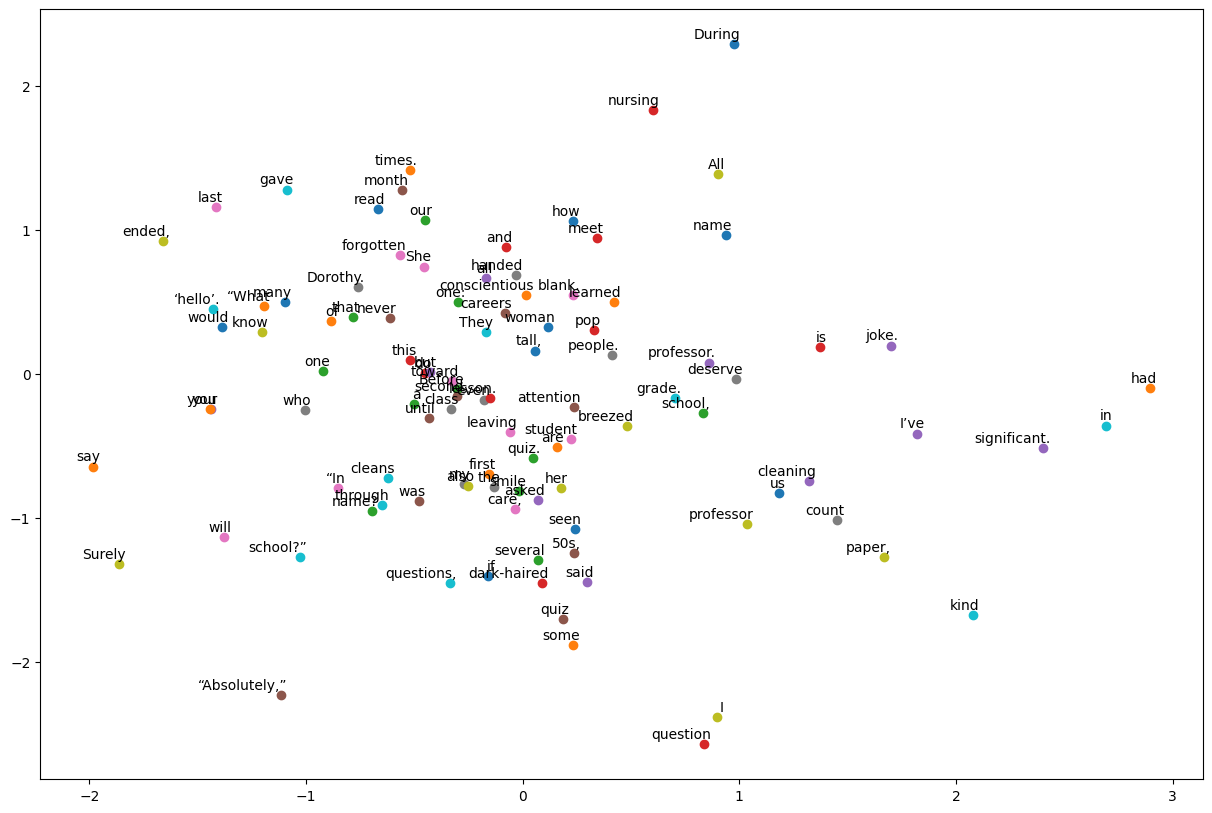

In [ ]:
plt.figure(figsize=(15,10))
for w in word_list:
    x = model.get_word_emdedding(w).detach().data.numpy()[0][0]
    y = model.get_word_emdedding(w).detach().data.numpy()[0][1]
    plt.scatter(x, y)
    plt.annotate(w, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()

Example usage: Get embedding for a specific word

In [ ]:
word_to_lookup = "professor"
word_index = word_to_ix[word_to_lookup]
embedding = model.embeddings(torch.tensor([word_index]))
print(f"Embedding for '{word_to_lookup}': {embedding.detach().numpy()}")

Embedding for 'professor': [[ 1.0339504  -1.0441276  -0.47256148 -0.28656548  0.04541509 -0.08407833
  -0.4774291   0.77990973  0.5617936   0.47602716  0.50591695  1.454545
  -0.76758975 -0.74886525  1.2013416   1.0100074  -0.7546559   0.3041942
  -0.13166447  0.72871846 -0.2944361   0.32557306 -0.3532223   1.9033924
   0.32401475 -1.0305138   0.58854604 -0.60594195  2.2598605  -0.9545606
   0.80060923 -0.60392517 -1.0180091   1.0415843   1.0205137   1.3777691
  -0.66174656 -0.69192827 -0.37807328  1.1641932  -0.15398294  0.66172695
  -0.8321935   0.67578983  0.23389068 -2.1026728  -0.8951347  -0.02609192
  -0.7259259  -0.6755896  -0.56820476  0.48297137 -0.5982175   0.1760924
  -0.18650816 -0.387211   -0.0353694   0.2985811   0.0954156   0.43408835
   1.8418614   1.6965492   0.9693169   1.5360589   0.12123743  0.02298231
   0.5058565   0.00578688  0.7319024  -0.7919299  -0.54000723 -0.43484864
  -0.14113864  0.23318379 -0.97997266  0.74639976 -1.0967771   1.3959169
  -1.2496043   0.80

### **Bonus**

Create a function to test the CBOW

In [ ]:
def CBOW_test(test_data, model):
    correct_ct = 0

    for context, target in data:
        context_vector = make_context_vector(context, word_to_ix)
        model.zero_grad()
        predicted = torch.argmax(model(context_vector), 1)

        if predicted[0] == torch.tensor([word_to_ix[target]]):
                correct_ct += 1

    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

In [ ]:
CBOW_test(data, model)

Accuracy: 100.0% (138/138)


In [ ]:
#TESTING
context = ['I’ve', 'never', 'that', 'lesson.']
context_vector = make_context_vector(context, word_to_ix)
a = model(context_vector)


In [ ]:
#Print result
print(f'Context: {context}\n')
print(f'Prediction: {ix_to_word[torch.argmax(a[0]).item()]}')

Context: ['I’ve', 'never', 'that', 'lesson.']

Prediction: forgotten




---



# **SkipGram implementation using Gensim**

The basic idea of word embedding is words that occur in similar context tend to be closer to each other in vector space. For generating word vectors in Python, modules needed are nltk and gensim. Run these commands in terminal to install `nltk` and `gensim`:



In [ ]:
!pip install -q nltk gensim

*  **NLTK**: For handling human language data, NLTK, or Natural Language Toolkit, is a potent Python library. It offers user-friendly interfaces to more than 50 lexical resources and corpora, including WordNet. A collection of text processing libraries for tasks like categorization, tokenization, stemming, tagging, parsing, and semantic reasoning are also included with NLTK.

*  **GENSIM**: Gensim is an open-source Python library that uses topic modelling and document similarity modelling to manage and analyse massive amounts of unstructured text data. It is especially well-known for applying topic and vector space modelling algorithms, such as Word2Vec and Latent Dirichlet Allocation (LDA), which are widely used.

Import the packages:

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('all')



Preprocessing the sentence and lowercasing for consistency

In [ ]:
sample = """
During my second month of nursing school, our professor gave us a pop quiz.
I was a conscientious student and had breezed through the questions, until I read the last one:
“What is the first name of the woman who cleans the school?”  Surely this was some kind of joke.
I had seen the cleaning woman several times. She was tall, dark-haired and in her 50s, but how would I know her name?
I handed in my paper, leaving the last question blank.  Before class ended, one student asked if the last question would count toward our quiz grade.
“Absolutely,” said the professor.  “In your careers you will meet many people. All are significant. They deserve your attention and care,
even if all you do is smile and say ‘hello’. I’ve never forgotten that lesson. I also learned her name was Dorothy.
"""
tokenized_corpus = word_tokenize(sample.lower())



Creating the model with the following parameters:

    vector_size ➡ Dimensionality of the word vectors
	window      ➡ Maximum distance between the current and predicted word within a sentence
	sg          ➡ Skip-Gram model (1 for Skip-Gram, 0 for CBOW)
	min_count   ➡ Ignores all words with a total frequency lower than this
	workers     ➡ Number of CPU cores to use for training the model

In [ ]:
skipgram_model = Word2Vec(sentences=[tokenized_corpus],
						vector_size=100,
						window=5,
						sg=1,
						min_count=1,
						workers=4)




Training and results:

In [ ]:
skipgram_model.train([tokenized_corpus], total_examples=1, epochs=10)
skipgram_model.save("skipgram_model.model")
loaded_model = Word2Vec.load("skipgram_model.model")
vector_representation = loaded_model.wv['professor']
print("Vector representation of 'word':", vector_representation)

Vector representation of 'word': [-0.0059317  -0.00750608 -0.00065949 -0.00528865  0.01131628 -0.00346623
 -0.00416692  0.00433376 -0.01212864 -0.00107502 -0.00852331 -0.00931184
  0.00611039  0.00990906  0.00724083 -0.01095293  0.0072213  -0.01274255
 -0.00735405 -0.01746839  0.00156192  0.00101453 -0.00210933 -0.00119087
  0.0090445   0.00932838 -0.00507922  0.00889856 -0.00148895 -0.00164855
 -0.00299112  0.0057431  -0.00429879 -0.0074217   0.00594352  0.00054991
  0.00200939 -0.0082092   0.00586103  0.00157395 -0.00975612 -0.00771454
  0.00596413  0.00196771  0.00253223  0.00048199 -0.0136444   0.0103444
  0.00153414 -0.00283681  0.00440374 -0.00256265 -0.00344435  0.00561642
 -0.00180435 -0.00415067  0.00854614  0.00600662  0.00432088  0.00144573
  0.00095204 -0.00901969  0.00590732  0.01116085 -0.00228807  0.00354022
 -0.00346102  0.00303863 -0.01174674  0.01142218  0.00114306  0.0121743
 -0.00283834 -0.00431208 -0.00085931 -0.00818776  0.00522721  0.00478769
  0.00012771  0.0028